In [8]:
# %% [markdown]
# tools/tavily_tool.py

# %%
from langchain_community.tools.tavily_search import TavilySearchResults

def get_tavily_tool():
    return TavilySearchResults(max_results=2)

In [9]:
# %% [markdown]
# tools/mcp_client_config.py

# %%
def get_mcp_config():
    return {
        "assistance": {
            "url": "http://localhost:9001/sse",
            "transport": "sse",
        },
        "contracting":{
            "url": "http://localhost:9002/sse",
            "transport": "sse",
        },
        "voting":{
            "url": "http://localhost:9003/sse",
            "transport": "sse",
        }
    }


In [10]:
# %% [markdown]
# graph/chatbot_graph.py

# %%
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

def build_graph(tools):
    model = ChatOpenAI(model="gpt-4o-mini")
    llm_with_tools = model.bind_tools(tools)

    def call_model(state: MessagesState):
        response = llm_with_tools.invoke(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node("call_model", call_model)
    builder.add_node("tools", ToolNode(tools))

    builder.add_edge(START, "call_model")
    builder.add_conditional_edges("call_model", tools_condition)
    builder.add_edge("tools", "call_model")
    builder.add_edge("call_model", END)

    return builder.compile()


In [11]:
# %% [markdown]
# main.py

# %%
import dotenv
import asyncio
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

# importa funciones definidas en las otras celdas
# si estás en un solo notebook, no necesitas cambiar nada
# si estuvieran en archivos separados, sería: from tools.tavily_tool import get_tavily_tool
get_tavily_tool = get_tavily_tool  # noqa
get_mcp_config = get_mcp_config    # noqa
build_graph = build_graph          # noqa

# %%
dotenv.load_dotenv()  # carga .env

# %%
async def main():
    async with MultiServerMCPClient(get_mcp_config()) as client:
        # Obtener herramientas del MCP
        mcp_tools = client.get_tools()
        print(f"Herramientas MCP disponibles ({len(mcp_tools)}):")
        for tool in mcp_tools:
            print(f"  - {tool.name}")

        # Agregar Tavily
        tools = mcp_tools + [get_tavily_tool()]

        # Construir grafo y mostrar diagrama
        graph = build_graph(tools)
        return graph


Herramientas MCP disponibles (15):
  - obtener_asistencias_congresista
  - obtener_ranking_asistencia
  - listar_faltas_recurrentes
  - obtener_historial_asistencia
  - obtener_estadisticas_generales_asistencia
  - buscar_contratos_por_ruc
  - listar_contratos_recientes
  - obtener_entidades_top_por_proveedor
  - consultar_estado_proveedor
  - clasificar_contratos_por_categoria
  - buscar_votaciones_por_tema
  - resumen_votaciones_congresista
  - obtener_votaciones_agrupadas_por_tema
  - obtener_participacion_votaciones
  - identificar_votos_clave_por_tema


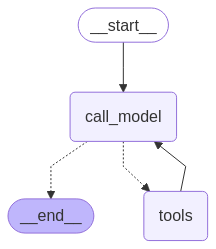

================================ Human Message =================================

what's 10 x 2 + 5?
None
================================== Ai Message ==================================

The calculation for \(10 \times 2 + 5\) is as follows:

1. Multiply: \(10 \times 2 = 20\)
2. Add: \(20 + 5 = 25\)

Therefore, \(10 \times 2 + 5 = 25\).
None


{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='d081c447-0e1a-4816-a5fa-7a71df1d0c51'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1K4cDMtcWPM1dwusWaIUZFA4', 'function': {'arguments': '{"query":"weather in Cusco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 575, 'total_tokens': 597, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BV6V3m7msPIzBDX76aTrvO3CG8MRb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9d4ef62c-97f7-45ac-8009-88116c975d37-0', tool_calls=[{'name': 'tavily_search_results_jso

In [12]:
# %% [markdown]
# Ejecutar main() y probar el grafo

# %%
graph = await main()
display(Image(graph.get_graph().draw_mermaid_png()))

# %%
agent_response = await graph.ainvoke({"messages": "what's 10 x 2 + 5?"})
for msg in agent_response["messages"]:
    print(msg.pretty_print())

# %%
await graph.ainvoke({"messages": "what's the weather in Cusco?"})


In [13]:
await graph.ainvoke({"messages": "Hola, que acciones puedo realizar?"})

{'messages': [HumanMessage(content='Hola, que acciones puedo realizar?', additional_kwargs={}, response_metadata={}, id='a7d04393-5885-4129-8180-835f298e60a0'),
  AIMessage(content='¡Hola! Puedes realizar diversas acciones relacionadas con el Congreso, como:\n\n1. **Consultar estadísticas de asistencia**: Obtén información sobre la asistencia de los congresistas, incluyendo un ranking de los que tienen mejor asistencia.\n2. **Revisar asistencias específicas**: Accede al resumen de asistencias, faltas y licencias de un congresista en particular.\n3. **Historial de asistencia**: Consulta el historial de asistencia de un congresista por legislatura.\n4. **Identificar faltas**: Lista congresistas que superan un umbral específico de faltas.\n5. **Consultar votaciones**: Investiga votaciones relevantes sobre temas específicos y estadísticas de votación de un congresista.\n6. **Participación en votaciones**: Analiza cuántas veces ha participado un congresista respecto al total de votaciones.\

In [14]:
await graph.ainvoke({"messages": "what's the weather in Cusco?"})

{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='881cf368-c209-4a06-9af5-74d46d615c22'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p4m60LQTPOYu4rG86Lm6HWTg', 'function': {'arguments': '{"query":"current weather in Cusco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 575, 'total_tokens': 598, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BV6VF4NHeMZPTp5wCO1krCH1VcT1l', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5b9ab781-b70f-4179-9fae-8e00b8d71a9d-0', tool_calls=[{'name': 'tavily_search_res

In [18]:
await graph.ainvoke({"messages": "Pueds listar los contratos recientes del ruc 20524320496?"})

{'messages': [HumanMessage(content='Pueds listar los contratos recientes del ruc 20524320496?', additional_kwargs={}, response_metadata={}, id='fe30337b-26f4-45bd-a9ed-fa3105325f53'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fm7FxQkb3rKHlztnWE1PsG3x', 'function': {'arguments': '{"ruc":"20524320496"}', 'name': 'listar_contratos_recientes'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 582, 'total_tokens': 606, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BV6Xgm0T29Z0FE1mSHoV9TbtNKfSA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6d210812-2a8d-42fe-9fc1-836433b800db-0', tool_calls=[{'name': 'lis